# Manual Labeling Data Preparation

In [1]:
import rasterio
import random
import matplotlib.pyplot as plt
import os
import sys
import datetime
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('rcnn'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Load in the training data

In [3]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

### Ingest the landsat imagery stacked into yearly seasonal tiles

We don't really need to do this here but the code is just copied from the rcnn code

In [4]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [5]:
tile_size = 13
class_count = 6

tile_list = ['028012', '029011', '028011']
class_dict = util.indexed_dictionary
#px = rnn_pixels.make_pixels(tile_size, tile_list)

In [6]:
#clean_px = rnn_pixels.make_clean_pix(tile_list, tile_size, landsat_datasets,lc_labels, canopy_labels, 100, buffer_pix=1)

### Testing for Runtime and Memory Usage

In [7]:
%load_ext line_profiler

In [9]:
%lprun -f rnn_pixels.tvt_pix_locations rnn_pixels.tvt_pix_locations(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, clean_pixels, 10, 10, 10, class_dict)

In [ ]:
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(clean_pixels, batch_size=1, flatten=True, canopy=True)

In [73]:
%lprun -f w_tile_gen.tile_generator w_tile_gen.tile_generator(clean_pixels[:2], batch_size=1, flatten=True, canopy=True)

In [74]:
%timeit w_tile_gen.tile_generator(clean_pixels[:2], batch_size=1, flatten=True, canopy=True)

6.15 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Generate Data for TVT

In [7]:
px = rnn_pixels.make_pixels(1, tile_list)

In [8]:
len(px)

75000000

In [9]:
2500000 / 2500 * 45 / 60 / 60

12.5

In [15]:
print(datetime.datetime.now())
px_to_use = px
clean_pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use, tile_size, buffer_pix=1)
print(datetime.datetime.now())
print(len(clean_pixels))

2020-02-07 16:03:29.854261
2020-02-08 19:57:27.823491
24268666


In [11]:
#clean_pixels_subset = clean_pixels[:10000]

In [16]:
print(datetime.datetime.now())
tvt_pixels = rnn_pixels.tvt_pix_locations(landsat_datasets, lc_labels, 
    canopy_labels, tile_size, tile_list, clean_pixels, 150, 150, 1500, class_dict)
print(datetime.datetime.now())
print('test:', len(tvt_pixels[0]), 'val:',len(tvt_pixels[1]), 'train:',len(tvt_pixels[2]))

2020-02-08 19:57:27.832484
Beginning TVT pixel creation.
Iterating through data and clipping for balance.

Processing Complete.
2020-02-09 05:26:35.530992
test: 900 val: 900 train: 9000


#### See if Data is Actually Balanced

In [36]:
class_count = 6

pixels = tvt_pixels[1]

# gets balanced pixels locations 
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=True)
total_labels = list()
count = 0
#buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

while count < len(pixels):
        image_b, label_b = next(w_generator)
        #print(image_b['tile_input'].shape)
        buckets[np.argmax(label_b["landcover"])].append({
            "pixel_loc" : pixels[count][0],
            "tile_name" : pixels[count][1],
            "landcover" : np.argmax(label_b["landcover"]),
            "canopy" : float(label_b["canopy"])
                                }) # appends pixels to dictionary
        count+=1
count = 0 
for z, j in buckets.items():
    print(z, len(j))
    count += len(j)
print(count) 

0 150
1 150
2 150
3 150
4 150
5 150
900


In [ ]:
# a run with 10,000,000 pixels 
4 hours for delete bad pixels and 2.5 hours to create tvt

ended up at

0 1500
1 1500
2 1500
3 1500
4 204
5 1500
7704

run through the pixels, buffer each pixel and add it to a geopandas dataset, convert that CRS to 4326 then save that geopandas dataset as a shapefile 

In [37]:
#count_per_class = 3000
count_per_class = 150 # 1667 * 6 ~= 10,000
pixel_coords = []

for lc_class in buckets.keys():
    for i, pixel in enumerate(buckets[lc_class]):
        landsat_ds = landsat_datasets[pixel["tile_name"]][0] # get the stack of ls datasets from that location and take the first
        x, y = landsat_ds.xy(pixel["pixel_loc"][0], pixel["pixel_loc"][1])
        pixel_coords.append({
        "x" : x,
        "y" : y,
        "row" : pixel["pixel_loc"][0],
        "col" : pixel["pixel_loc"][1],
        "label" : pixel["landcover"],
        "canopy" : pixel["canopy"],
        "tile_name" : pixel["tile_name"]
                        })
        if i > count_per_class:
            break

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ddb5f77b8>]],
      dtype=object)

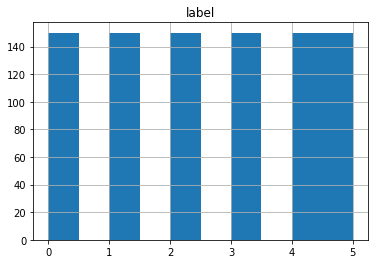

In [38]:
# create a dataframe from the pixel coordinates
df = pd.DataFrame(pixel_coords)
df.hist(column="label")

In [39]:
landsat_datasets["029011"][0].crs

CRS.from_wkt('PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

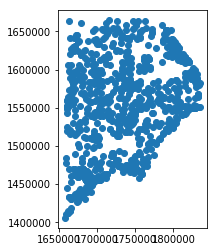

In [40]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y), crs=landsat_datasets["028011"][0].crs)
gdf.plot()

In [41]:
# buffer by 15 meters to make 30x30 pixel
buffer = gdf.buffer(15)

envelope = buffer.envelope  
gdf.geometry = envelope
gdf.head()

,canopy,col,label,row,tile_name,x,y,geometry
0,0.0,2815,0,4079,028011,1718880.0,1542420.0,"POLYGON ((1718865 1542405, 1718895 1542405, 17..."
1,0.0,2684,0,4338,028011,1714950.0,1534650.0,"POLYGON ((1714935 1534635, 1714965 1534635, 17..."
2,0.0,2069,0,4956,028011,1696500.0,1516110.0,"POLYGON ((1696485 1516095, 1696515 1516095, 16..."
3,0.0,4390,0,1075,028011,1766130.0,1632540.0,"POLYGON ((1766115 1632525, 1766145 1632525, 17..."
4,0.0,4538,0,703,028011,1770570.0,1643700.0,"POLYGON ((1770555 1643685, 1770585 1643685, 17..."


In [42]:
gdf = gdf.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf.head()

,canopy,col,label,row,tile_name,x,y,geometry
0,0.0,2815,0,4079,028011,1718880.0,1542420.0,POLYGON ((-76.78849850392892 35.36879555337595...
1,0.0,2684,0,4338,028011,1714950.0,1534650.0,POLYGON ((-76.84850691030618 35.30782083511083...
2,0.0,2069,0,4956,028011,1696500.0,1516110.0,POLYGON ((-77.08976824327264 35.17825971005278...
3,0.0,4390,0,1075,028011,1766130.0,1632540.0,POLYGON ((-76.06717326553576 36.07042880439412...
4,0.0,4538,0,703,028011,1770570.0,1643700.0,POLYGON ((-75.99239772831309 36.15961661284905...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2dd40b1d30>]],
      dtype=object)

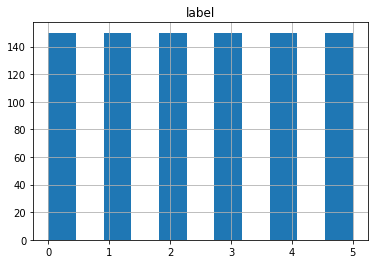

In [43]:
gdf.hist(column="label", bins=11)

In [44]:
gdf.to_file("val_buffered_points.shp",driver='ESRI Shapefile')

In [127]:
reopened_gdf = gpd.read_file("buffered_points.shp")
reopened_gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028012,1761360.0,1488030.0,POLYGON ((-76.45020728592766 34.81590242273489...
1,0.0,0,028011,1681560.0,1662390.0,POLYGON ((-76.92900325896298 36.48521077384399...
2,0.0,0,028012,1716840.0,1502310.0,POLYGON ((-76.89957784087977 35.02127890428567...
3,0.0,0,028012,1755480.0,1474380.0,POLYGON ((-76.54424306552457 34.70714544743746...
4,0.0,0,028011,1746030.0,1604430.0,POLYGON ((-76.35222097208796 35.86193505990429...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ebdeba320>]],
      dtype=object)

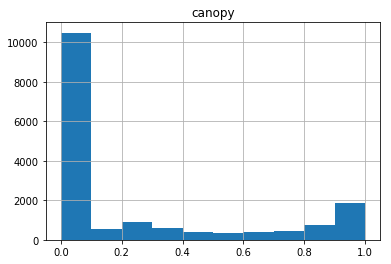

In [146]:
reopened_gdf.hist(column="canopy")

In [130]:
reopened_gdf.crs

{'init': 'epsg:4326'}

In [133]:
reopened_gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028012,1761360.0,1488030.0,POLYGON ((-76.45020728592766 34.81590242273489...
1,0.0,0,028011,1681560.0,1662390.0,POLYGON ((-76.92900325896298 36.48521077384399...
2,0.0,0,028012,1716840.0,1502310.0,POLYGON ((-76.89957784087977 35.02127890428567...
3,0.0,0,028012,1755480.0,1474380.0,POLYGON ((-76.54424306552457 34.70714544743746...
4,0.0,0,028011,1746030.0,1604430.0,POLYGON ((-76.35222097208796 35.86193505990429...


In [144]:
for index, row in df.iterrows():
    print(row['tile_name'])
    print(row['canopy'])
    print(row['geometry'])
    print(row['geometry'].centroid)
    break

028012
0.0
POLYGON ((1761345 1488015, 1761375 1488015, 1761375 1488045, 1761345 1488045, 1761345 1488015))
POINT (1761360 1488030)


In [148]:
pd.cut(reopened_gdf['canopy'], 10).value_counts().sort_index()

(-0.001, 0.1]    10490
(0.1, 0.2]         625
(0.2, 0.3]         827
(0.3, 0.4]         656
(0.4, 0.5]         417
(0.5, 0.6]         312
(0.6, 0.7]         376
(0.7, 0.8]         502
(0.8, 0.9]         779
(0.9, 1.0]        1757
Name: canopy, dtype: int64